In [28]:
import os
import sys
from datetime import datetime
import keras

import argparse
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Adamax
import keras.backend as K

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from func import * 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/

In [29]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-d' ,'--data', type=str, default='/home/katieyth/gynecology/data/data_cmu_ctu.csv', help='data')
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-y' ,'--target', type=str, default='multi', help='prediction target')
# variability	UA	 deceleration management
 
# input parameter
parser.add_argument('-th','--acceptable_zeros_threshold', type=float, default=200, help='acceptable number of missing values in raw data')
parser.add_argument('-l' ,'--length', type=int, default=600, help='length of input')
parser.add_argument('-ks','--k_slice', type=int, default=1, help='a input will be sliced into k_slice segments when testing')
parser.add_argument('-c' ,'--n_channel', type=int, default=2, help='number of input channels')
parser.add_argument('-rn','--random_noise', type=int, default=0, help='add Gaussian noise (mean=0, std=0.01) into inputs')
parser.add_argument('-nm','--normalized', type=int, default=1, help='whether conduct channel-wise normalization')
parser.add_argument('-ctu_cmu' ,'--ctu_cmu', type=str, default='cmu', help='train_ctu_test_cmu')

# data augmentation 
parser.add_argument('-aug_fliplr' ,'--aug_fliplr', type=int, default=0, help='reverse time series')
parser.add_argument('-shift' ,'--DA_Shift', type=int, default=1, help='')
parser.add_argument('-scale' ,'--DA_Scale', type=int, default=1, help='')
parser.add_argument('-randsamp' ,'--DA_RandSampling', type=int, default=1, help='')


# model parameters
parser.add_argument('-struc' ,'--struc', type=str, default='mimic_previous_FHB', help='deeper or shallower')
parser.add_argument('-k' ,'--kernel_size', type=int, default=3, help='kernel size')
parser.add_argument('-f' ,'--filters', type=int, default=64, help='base number of filters')
parser.add_argument('-ly' ,'--layers', type=int, default=5, help='number of residual layers')
parser.add_argument('-a' ,'--activation', type=str, default='relu', help='activation function')
parser.add_argument('-i' ,'--kernel_initializer', type=str, default='RandomNormal', help='kernel initialization method')
parser.add_argument('-l2','--l2', type=float, default=0.01, help='coefficient of l2 regularization')

# hyper-parameters
parser.add_argument('-lr','--learning_rate', type=float, default=1e-4, help='learning_rate')
parser.add_argument('-reduce_lr_patience','--reduce_lr_patience', type=int, default=50, help='reduce_lr_patience')
parser.add_argument('-bs','--batch_size', type=int, default=27, help='batch_size')
parser.add_argument('-ep','--epoch', type=int, default=15, help='epoch')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')
parser.add_argument('-mntr','--monitor', type=str, default='val_man_acc', help='val_acc or val_loss')

parser.add_argument('-g' ,'--gpu_id', type=str, default='7', help='GPU ID')
parser.add_argument('-rs' ,'--random_state', type=int, default=13, help='random state when train_test_split')
parser.add_argument('-fn' ,'--summary_file', type=str, default=None, help='summary filename')

FLAG = parser.parse_args([])
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id

In [30]:
def data_preprocess_test(Xvalid, Yvalid, length=600):
    Xtest = np.empty((Xvalid.shape[0], length, Xvalid.shape[2]))
    for i in range(Xvalid.shape[0]):
        Xtest[i,:,:] = data_normalize(Xvalid[i,0:600,:])
    Ytest = Yvalid.copy()
    return Xtest, Ytest

In [31]:
def func_FHB2class(x):
    if  x <= 110:
        return "1"
    elif x <= 160:
        return "0"
    else:
        return "1"

In [32]:
### data preparing
d = pd.read_csv(os.path.join(FLAG.data))
d['FHB_class'] = d['FHB'].apply(func_FHB2class)


# replace 0 (no readings) with np.nan for later substitution
for k in d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        d.loc[d[k]==0, k] = np.nan

# choose dataset type
if FLAG.ctu_cmu == 'trans':
    train_d = d[d['ID'].str.contains('CTU_')]
    valid_d = d[d['ID'].str.contains('CMU_')]
elif FLAG.ctu_cmu == 'mix':
    train_d,valid_d = train_test_split(d, test_size=0.3, random_state=FLAG.random_state, stratify =d['management'])
elif FLAG.ctu_cmu == 'cmu':
    dd = d[d['ID'].str.contains('CMU_')]
    dd['multi_label'] = dd['management'].map(str)+'_'+dd['UA'].map(str)+'_'+dd['variability'].map(str)+'_'+dd['deceleration'].map(str)+'_'+dd['FHB_class'].map(str)
    dd['multi_label_count'] = dd.groupby('multi_label')['multi_label'].transform('count')
    dd_split = dd[dd['multi_label_count']!=1]
    dd_force_train = dd[dd['multi_label_count']==1]
    train_d,valid_d = train_test_split(dd_split, test_size=0.3, random_state=FLAG.random_state, stratify =dd_split['multi_label'])
    train_d = pd.concat([train_d, dd_force_train])
elif FLAG.ctu_cmu == 'ctu':
    dd = d[d['ID'].str.contains('CTU_')]
    dd['multi_label'] = dd['management'].map(str)+'_'+dd['UA'].map(str)+'_'+dd['variability'].map(str)+'_'+dd['deceleration'].map(str)+'_'+dd['FHB_class'].map(str)
    dd['multi_label_count'] = dd.groupby('multi_label')['multi_label'].transform('count')
    dd_split = dd[dd['multi_label_count']!=1]
    dd_force_train = dd[dd['multi_label_count']==1]
    train_d,valid_d = train_test_split(dd_split, test_size=0.3, random_state=FLAG.random_state, stratify =dd_split['multi_label'])
    train_d = pd.concat([train_d, dd_force_train])
elif FLAG.ctu_cmu == 'trans_inv':
    train_d = d[d['ID'].str.contains('CMU_')]
    valid_d = d[d['ID'].str.contains('CTU_')]
    
# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
target_list = ['management', 'UA', 'variability', 'deceleration', 'FHB_class', 'management']
target_dict = {'management':3,
               'UA':2,
               'variability':2,
               'deceleration':4,
               'FHB_class':4,
               'management':3}
Ytrain = [(keras.utils.to_categorical(np.array(train_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]
Yvalid = [(keras.utils.to_categorical(np.array(valid_d[c_name]),num_classes=target_dict[c_name])) for c_name in target_list]

#weight balancing or not
if FLAG.weight_balance:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        y_integers = np.argmax(Ytrain[idx], axis=1)
        d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
        class_weight = dict(enumerate(d_class_weight))
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)
else:
    weight_list = []
    for idx, c_name in enumerate(target_list):
        class_weight = dict()
        for i in range(target_dict[c_name]):
            class_weight[i] = 1
        print('class weight: {0}'.format(class_weight))
        weight_list.append(class_weight)

Xtest, Ytest =data_preprocess_test(Xvalid, Yvalid)


if FLAG.aug_fliplr:
    Xtrain_copy = Xtrain.copy()
    for i in range(len(Xtrain)):
        Xtrain_copy[i] = np.fliplr([Xtrain[i]])[0]
        print(i,'/',len(Xtrain), end= '\r')
    Xtrain = np.vstack((Xtrain, Xtrain_copy))
    Ytrain = np.vstack((Ytrain, Ytrain))

print('train:', len(train_d))
print('test:', len(valid_d))

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


class weight: {0: 0.5232974910394266, 1: 1.0354609929078014, 2: 8.11111111111111}
class weight: {0: 5.615384615384615, 1: 0.5488721804511278}
class weight: {0: 0.5658914728682171, 1: 4.294117647058823}
class weight: {0: 0.4397590361445783, 1: 1.9210526315789473, 2: 0.8690476190476191, 3: 18.25}
class weight: {0: 0.5069444444444444, 1: 36.5}
class weight: {0: 0.5232974910394266, 1: 1.0354609929078014, 2: 8.11111111111111}
train: 146
test: 61


# model

In [6]:
if FLAG.struc =='deeper':
    from model_multitask_more import build_model
elif FLAG.struc =='shallower':
    from model_multitask import build_model
elif FLAG.struc =='man_concat':
    from model_multitask_more_concat import build_model
elif FLAG.struc =='man_concat_shallower':
    from model_multitask_more_concat_shallower import build_model
elif FLAG.struc =='mimic_previous':
    from model_multitask_more_concat_mimic_previous import build_model
elif FLAG.struc =='mimic_previous_FHB':
    from model_multitask_more_concat_mimic_previous_FHB import build_model

In [7]:
augtool = (DA_Shift,DA_Scale,DA_RandSampling)
choose_augtool = (FLAG.DA_Shift,FLAG.DA_Scale,FLAG.DA_RandSampling)
augset = [x for x, y in zip(augtool, choose_augtool) if y == 1]
augset

[<function func.DA_Shift>,
 <function func.DA_Scale>,
 <function func.DA_RandSampling>]

In [8]:
def my_generator(Xtrain, Ytrain, tg_list, tg_dict,
                 length=300, n_channel=2,  batch_size=16, prob=0.5,
                 aug_func=[], random_noise = False, normalized = True):
    n_sample = Xtrain.shape[0]
    n_length = Xtrain.shape[1]
    ind = list(range(n_sample))
    x = np.empty((batch_size, length, n_channel), dtype=np.float)
    
    y_list = [(np.empty((batch_size, tg_dict[c_name]), dtype=int)) for c_name in tg_list]

    while True:
        np.random.shuffle(ind)
        for i in range(n_sample//batch_size):
            if length==600:
                st = 0
            else:
                st = random.choice(np.arange(0, Xtrain.shape[1] - length))
            i_batch = ind[i*batch_size:(i+1)*batch_size]
            for j, k in enumerate(i_batch):
                x[j,:] = data_preprocess(Xtrain[k,st:(st+length),:], aug_func=aug_func, prob=prob, random_noise=random_noise, normalized=normalized)
                for c_idx in range(len(tg_list)):
                    y_list[c_idx][j,:] = Ytrain[c_idx][k,:] 
                
            yield x, y_list

In [9]:
train_gen = my_generator(Xtrain, Ytrain, 
                         tg_list = target_list,
                         tg_dict = target_dict,
                        length=FLAG.length, 
                        n_channel=FLAG.n_channel, 
                        random_noise=FLAG.random_noise,
                        normalized=FLAG.normalized,
                        batch_size=FLAG.batch_size,
                        aug_func=augset,
                        prob=0.25)

In [10]:
# Get a "l2 norm of gradients" tensor
def get_gradient_norm(model):
    with K.name_scope('gradient_norm'):
        grads = K.gradients(model.total_loss, model.trainable_weights)
        norm = K.sqrt(sum([K.sum(K.square(g)) for g in grads]))
    return norm

In [11]:
# import numpy as np
# from keras.callbacks import Callback
# from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
# class Metrics(Callback):
# #     def on_train_begin(self, logs={}):

#     def __init__(self):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []
#     def get_data(self, Xtest, Ytest, logs={}):
#         self.X = Xtest
#         self.Y = Ytest
#         self.c_dict = {'management':0,
#                        'UA':1,
#                        'variability':2,
#                        'deceleration':3,
#                        'FHB':4,
#                        'management_concat':5}
#         self.target = 'management'
#     def on_epoch_end(self, epoch, logs={}):
#         Pred = self.model.predict(self.X)
#         val_predict = np.argmax(Pred[self.c_dict[self.target]] , axis=1)
#         val_targ = np.argmax(Ytest[self.c_dict[self.target]], axis=1)
#         _val_f1 = f1_score(val_targ, val_predict, average=None)
#         _val_recall = recall_score(val_targ, val_predict, average=None)
#         _val_precision = precision_score(val_targ, val_predict, average=None)
        
# #         print("************%f *********** %f" %((sum(_val_f1)/len(_val_f1)), max(self.val_f1s)))
#         if (sum(_val_f1)/len(_val_f1))> max(self.val_f1s):
#             print('HEEEEEEEEEEEELLLLLLLLLLLLLLLLLLLLLLLLLLO')
#         print(val_f1s)
        
#         self.val_f1s.append(sum(_val_f1)/len(_val_f1))
#         self.val_recalls.append(sum(_val_recall)/len(_val_recall))
#         self.val_precisions.append(sum(_val_precision)/len(_val_precision))
#         print(val_f1s)
#         print(" — val_f1: %f — val_recall: %f — val_precision %f" %(sum(_val_f1)/len(_val_f1),
#                                                                     sum(_val_recall)/len(_val_recall),
#                                                                     sum(_val_precision)/len(_val_precision)))
# m = Metrics()
# m.get_data(Xtest,Ytest)

In [12]:
print("===== create directory =====")
model_id = FLAG.target + "_" + datetime.now().strftime("%y%m%d%H%M%S")
model_save = os.path.join(FLAG.model_save, FLAG.target, model_id)
summary_save = os.path.join(FLAG.model_save, FLAG.target, 'summary_'+FLAG.target+'.csv')

if not os.path.exists(model_save):
    os.makedirs(model_save)
    print(model_save)

# declare model and compile it 
model = build_model(length=FLAG.length, n_channel=FLAG.n_channel,  filters=FLAG.filters,
                    kernel_size=FLAG.kernel_size, layers=FLAG.layers,
                activation=FLAG.activation, kernel_initializer=FLAG.kernel_initializer, l_2=FLAG.l2)
model.summary()
lr_rate = FLAG.learning_rate
adam = Adamax(lr_rate, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay = 0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# 還沒有 compile 前拿不到 total loss 這個 tensor, 也拿不到 metrics 這個東西
# Append the "l2 norm of gradients" tensor as a metric
model.metrics_names.append("gradient_norm")
model.metrics_tensors.append(get_gradient_norm(model))


csv_logger = CSVLogger(os.path.join(model_save, 'training.log'), append = True)
checkpoint = ModelCheckpoint(os.path.join(model_save, 'model.h5'), 
                                            monitor=FLAG.monitor, 
                                            verbose=1, 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='auto',
                                            period=1)
earlystop = EarlyStopping(monitor = FLAG.monitor, patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor=FLAG.monitor, factor = 0.5, patience = FLAG.reduce_lr_patience, min_lr = 0, cooldown = 5, verbose = True)

===== create directory =====
/home/katieyth/gynecology/model_save/multi/multi_190116171430
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 600, 64)      448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 600, 64)      256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 600, 64)      0           batch_normalization_1[0][0]      
__________________

__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 128)          512         global_average_pooling1d_3[0][0] 
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128)          512         global_average_pooling1d_4[0][0] 
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 128)          512         global_average_pooling1d_5[0][0] 
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       batch_normalization_13[0][0]     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       batch_normalization_15[0][0]     
__________

In [13]:
model.fit_generator(generator=train_gen,
                    class_weight={'man': weight_list[0],
                                  'ua' : weight_list[1],
                                  'var': weight_list[2],
                                  'dec': weight_list[3],
                                  'fhb': weight_list[4],
                                  'man_concat':weight_list[5]},
                    validation_data=(Xtest, {'man':Ytest[0],
                                             'ua' :Ytest[1],
                                             'var':Ytest[2],
                                             'dec':Ytest[3],
                                             'fhb':Ytest[4],
                                             'man_concat':Ytest[5]}),
                    steps_per_epoch=50, 
                    epochs=FLAG.epoch,
                    verbose=1,
                    callbacks=[csv_logger,
                               reduce_lr, 
                               checkpoint,
                               earlystop
                              ])

Epoch 1/15
49/50 [============================>.] - ETA: 0s - loss: 32.2370 - man_loss: 1.0695 - ua_loss: 0.6798 - var_loss: 0.7034 - dec_loss: 1.3313 - fhb_loss: 0.9728 - man_concat_loss: 1.3421 - man_acc: 0.3930 - ua_acc: 0.3091 - var_acc: 0.4429 - dec_acc: 0.3477 - fhb_acc: 0.4361 - man_concat_acc: 0.1224 - gradient_norm: 40.0039
Epoch 00001: val_man_acc improved from -inf to 0.45902, saving model to /home/katieyth/gynecology/model_save/multi/multi_190116171430/model.h5
50/50 [==============================] - 22s 432ms/step - loss: 32.2221 - man_loss: 1.0666 - ua_loss: 0.6771 - var_loss: 0.6998 - dec_loss: 1.3269 - fhb_loss: 0.9784 - man_concat_loss: 1.3362 - man_acc: 0.3926 - ua_acc: 0.3111 - var_acc: 0.4444 - dec_acc: 0.3474 - fhb_acc: 0.4370 - man_concat_acc: 0.1230 - gradient_norm: 39.9965 - val_loss: 32.4731 - val_man_loss: 1.1028 - val_ua_loss: 0.8235 - val_var_loss: 0.7242 - val_dec_loss: 1.1929 - val_fhb_loss: 0.8567 - val_man_concat_loss: 1.6852 - val_man_acc: 0.4590 - val

In [14]:
def plot_keras_csv_logger(csv_logger, save_dir='', accuracy=False, gradient=False):
    if type(csv_logger) is str:
        loss = pd.read_table(csv_logger, delimiter=',')
    else:
        loss = pd.read_table(csv_logger.filename, delimiter=',')
    print('min val_loss {0} at epoch {1}'.format(min(loss.val_loss), np.argmin(loss.val_loss)))
    plt.plot(loss.epoch, loss.loss, label='loss')
    plt.plot(loss.epoch, loss.val_loss, label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.show()
    plt.close()

    if accuracy:
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_dec_acc), np.argmax(loss.val_dec_acc)))
        plt.plot(loss.epoch, loss.dec_acc, label='dec_acc')
        plt.plot(loss.epoch, loss.val_dec_acc, label='val_dec_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'dec_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_var_acc), np.argmax(loss.val_var_acc)))
        plt.plot(loss.epoch, loss.var_acc, label='var_acc')
        plt.plot(loss.epoch, loss.val_var_acc, label='val_var_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'var_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_ua_acc), np.argmax(loss.val_ua_acc)))
        plt.plot(loss.epoch, loss.ua_acc, label='ua_acc')
        plt.plot(loss.epoch, loss.val_ua_acc, label='val_ua_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'ua_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_man_acc), np.argmax(loss.val_man_acc)))
        plt.plot(loss.epoch, loss.man_acc, label='man_acc')
        plt.plot(loss.epoch, loss.val_man_acc, label='val_man_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'man_acc.png'))
        plt.show()
        plt.close()
        
        print('max val_accu {0} at epoch {1}'.format(max(loss.val_man_concat_acc), np.argmax(loss.val_man_concat_acc)))
        plt.plot(loss.epoch, loss.man_concat_acc, label='man_concat_acc')
        plt.plot(loss.epoch, loss.val_man_concat_acc, label='val_man_concat_acc')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.savefig(os.path.join(save_dir, 'man_concat_acc.png'))
        plt.show()
        plt.close()
    if gradient:
        plt.plot(loss.epoch, loss.gradient_norm, label='gradient_norm')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('gradient_norm')
        plt.savefig(os.path.join(save_dir, 'gradient.png'))
        plt.show()
        plt.close()

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


min val_loss 28.9863498249992 at epoch 14


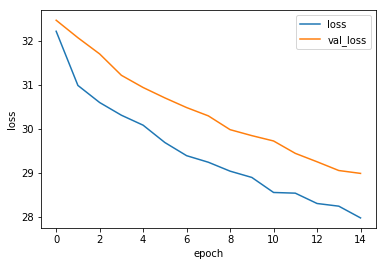

max val_accu 0.7213114832268387 at epoch 9


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


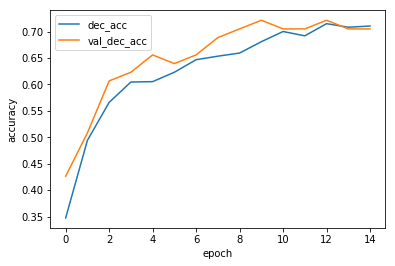

max val_accu 0.7377049248726641 at epoch 13


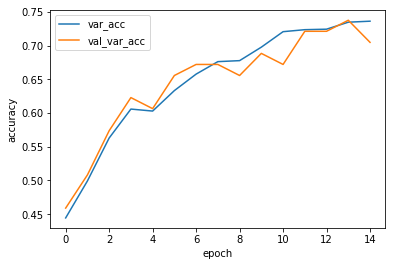

max val_accu 0.7540983489302339 at epoch 13


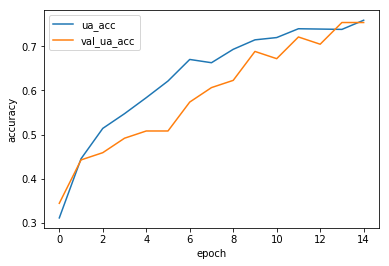

max val_accu 0.6557377254376646 at epoch 6


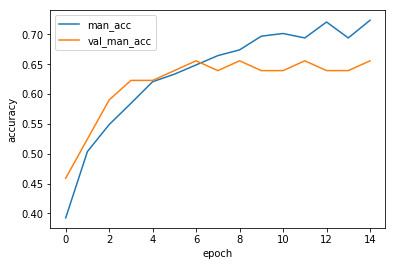

max val_accu 0.6885245911410598 at epoch 8


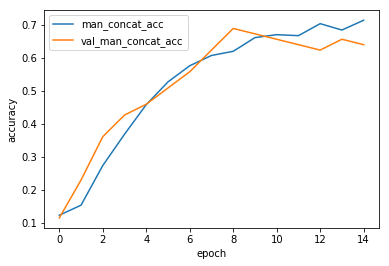

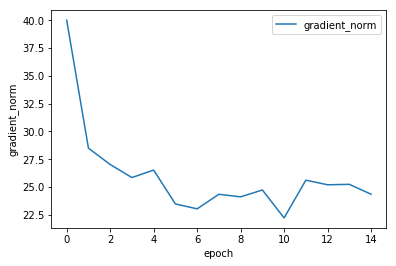

In [15]:
plot_keras_csv_logger(csv_logger, save_dir=model_save, accuracy=True, gradient = True)

# test saved model

In [16]:
path = model_save
print(path)
loss = pd.read_table(csv_logger.filename, delimiter=',')
best_val_loss = np.min(loss.val_loss)
best_epoch = np.argmin(loss.val_loss)


# model_id =  'multi_190114123245'
# path = os.path.join(FLAG.model_save,FLAG.target, model_id)
# loss = pd.read_table(os.path.join(path, 'training.log'), delimiter=',')
# best_val_loss = np.min(loss.val_loss)
# best_epoch = np.argmin(loss.val_loss)
# model_save = '.'


/home/katieyth/gynecology/model_save/multi/multi_190116171430


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [17]:
# evaluate validation set
trained_model = load_model(os.path.join(path,'model.h5'))
Pred = trained_model.predict(Xtest)


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save_dir=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if not save_dir =='':
        plt.savefig(os.path.join(save_dir))

management accuracy :  0.6557377049180327
management_recall-0 : 0.8000
management_recall-1 : 0.3500
management_recall-2 : 1.0000
management_recall-average : 0.7167
management_precision-0: 0.7805
management_precision-1: 0.5000
management_precision-2: 0.1667
management_precision-average : 0.4824
management_F1-0: 0.7901
management_F1-1: 0.4118
management_F1-2: 0.2857
management_F1-average : 0.4959
Confusion matrix, without normalization
[[32  7  1]
 [ 9  7  4]
 [ 0  0  1]]
UA accuracy :  0.5737704918032787
UA_recall-0 : 1.0000
UA_recall-1 : 0.5185
UA_recall-average : 0.7593
UA_precision-0: 0.2121
UA_precision-1: 1.0000
UA_precision-average : 0.6061
UA_F1-0: 0.3500
UA_F1-1: 0.6829
UA_F1-average : 0.5165
Confusion matrix, without normalization
[[ 7  0]
 [26 28]]
variability accuracy :  0.6721311475409836
variability_recall-0 : 0.6296
variability_recall-1 : 1.0000
variability_recall-average : 0.8148
variability_precision-0: 1.0000
variability_precision-1: 0.2593
variability_precision-average

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


deceleration_F1-average : 0.4607
Confusion matrix, without normalization
[[26  5  1  4]
 [ 4  4  0  0]
 [ 2  5 10  0]
 [ 0  0  0  0]]
FHB accuracy :  0.9016393442622951
FHB_recall-0 : 0.9016
FHB_recall-1 : nan
FHB_recall-2 : nan
FHB_recall-average : nan
FHB_precision-0: 1.0000
FHB_precision-1: 0.0000
FHB_precision-2: 0.0000
FHB_precision-average : 0.3333
FHB_F1-0: 0.9483
FHB_F1-1: 0.0000
FHB_F1-2: 0.0000
FHB_F1-average : 0.3161
Confusion matrix, without normalization
[[55  4  2]
 [ 0  0  0]
 [ 0  0  0]]
management_concat accuracy :  0.5573770491803278
management_concat_recall-0 : 0.5750
management_concat_recall-1 : 0.5000
management_concat_recall-2 : 1.0000
management_concat_recall-average : 0.6917
management_concat_precision-0: 0.8519
management_concat_precision-1: 0.4545
management_concat_precision-2: 0.0833
management_concat_precision-average : 0.4632
management_concat_F1-0: 0.6866
management_concat_F1-1: 0.4762
management_concat_F1-2: 0.1538
management_concat_F1-average : 0.4389
Co

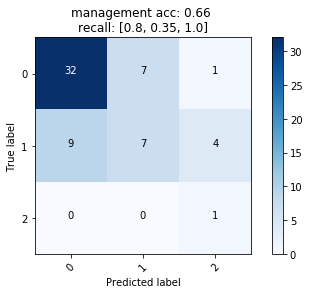

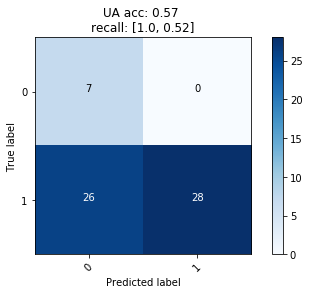

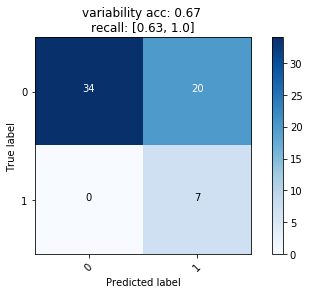

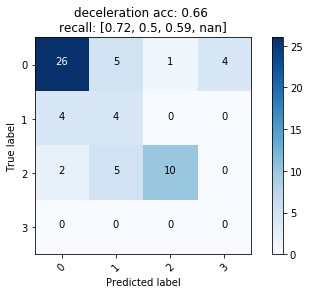

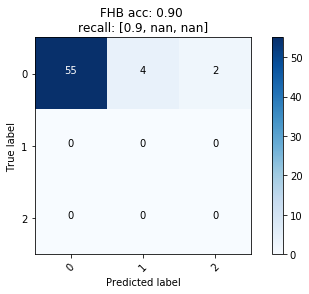

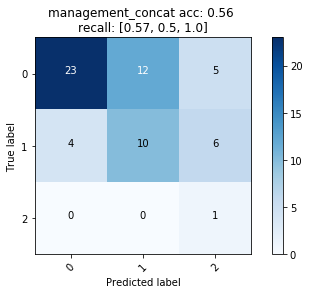

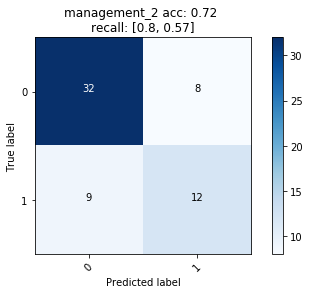

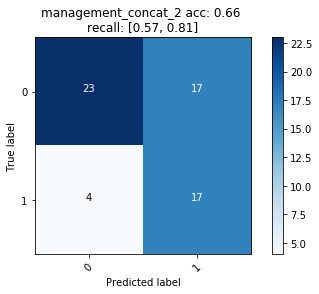

In [23]:
# save into dictionary
sav = vars(FLAG)
sav['epoch'] = best_epoch
sav['val_loss'] = best_val_loss
sav['model_id'] = model_id

c_list = ['management', 'UA', 'variability', 'deceleration', 'FHB','management_concat']
for c in range(6):
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
#         _val_recall = recall_score(val_targ, val_predict, average=None)
#         _val_precision = precision_score(val_targ, val_predict, average=None)
    
    

    print('%s accuracy : ' % (c_list[c]), val_accu)
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[c],i, recall[i]))
        sav['%s_recall-%d' %(c_list[c], i)] = recall[i]
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_recall-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[c],i, precision[i]))
        sav['%s_precision-%d' %(c_list[c], i)] = precision[i]
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_precision-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[c],i, f1[i]))
        sav['%s_F1-%d' %(c_list[c], i)] = f1[i]
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[c], sum(tmp_list)/len(tmp_list)))
    sav['%s_F1-average' %(c_list[c])] = sum(tmp_list)/len(tmp_list)
    
    sav['val_%s_acc' %(c_list[c])] = val_accu

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)),
                          title='%s acc: %.2f \nrecall: %s' %(c_list[c], val_accu,rcl),
                          save_dir=model_save+'/%s_cm.png' % (c_list[c]) )
# force management to 2 label 
c_list = ['management_2', 'management_concat_2']
for idx, c in enumerate([0,5]):
    # evaluate by every segment
    ypred_aug = np.argmax(Pred[c] , axis=1)
    ytest_aug = np.argmax(Ytest[c], axis=1)
    ypred_aug[ypred_aug>1]=1
    ytest_aug[ytest_aug>1]=1

    cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)
    recall = np.diag(cfm) / np.sum(cfm, axis=1)
    precision = np.diag(cfm) / np.sum(cfm, axis=0)
    val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)
    f1 = f1_score(y_pred=ypred_aug, y_true=ytest_aug, average=None)
    
    tmp_list = []
    for i in range(len(recall)):
        print('%s_recall-%d : %.4f' %(c_list[idx],i, recall[i]))
        sav['%s_recall-%d' %(c_list[idx], i)] = recall[i]
        tmp_list.append(recall[i])
    print('%s_recall-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_recall-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(precision)):
        print('%s_precision-%d: %.4f' % (c_list[idx],i, precision[i]))
        sav['%s_precision-%d' %(c_list[idx], i)] = precision[i]
        tmp_list.append(precision[i])
    print('%s_precision-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_precision-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    tmp_list = []
    for i in range(len(f1)):
        print('%s_F1-%d: %.4f' % (c_list[idx],i, f1[i]))
        sav['%s_F1-%d' %(c_list[idx], i)] = f1[i]
        tmp_list.append(f1[i])
    print('%s_F1-average : %.4f' %(c_list[idx], sum(tmp_list)/len(tmp_list)))
    sav['%s_F1-average' %(c_list[idx])] = sum(tmp_list)/len(tmp_list)
    
    sav['val_%s_acc' %(c_list[idx])] = val_accu

    plt.figure()
    rcl = [round(recall[i],2) for i in range(len(recall))]
    plot_confusion_matrix(cfm, classes=np.arange(len(recall)), 
                          title='%s acc: %.2f \nrecall: %s' %(c_list[idx], val_accu,rcl),
                          save_dir=model_save+'/%s_cm.png' % (c_list[idx]) )


In [24]:
# append into summary files
dnew = pd.DataFrame(sav, index=[0])
if os.path.exists(summary_save):
    dori = pd.read_csv(summary_save)
    dori = pd.concat([dori, dnew])
    dori.to_csv(summary_save, index=False)
else:
    dnew.to_csv(summary_save, index=False)

print(summary_save)



/home/katieyth/gynecology/model_save/multi/summary_multi.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]
